# Executive Compensation Extraction Pipeline

This notebook processes SEC DEF14A filings to extract Summary Compensation Tables using:
1. **MinerU** - PDF to structured data conversion
2. **Qwen3-VL** - Vision-Language Model for table classification and extraction

## 1. Setup & Configuration

In [51]:
%matplotlib inline

# Standard library
import json
import random
import sys
from pathlib import Path

# Third party
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import display
from openai import AsyncOpenAI
from PIL import Image as PILImage
from tqdm import tqdm

# Local imports
sys.path.insert(0, str(Path("..").resolve()))
from src import (
    convert_docs_to_pdf,
    process_pdfs_with_mineru,
    extract_tables_from_output,
    merge_consecutive_tables,
    find_summary_compensation_in_doc,
    extract_all_summary_compensation,
    save_classification_results,
    save_extraction_results,
    display_all_results,
    display_table_preview,
    TableType,
    fix_all_orphan_images,
)

In [52]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Paths
BASE_PATH = Path("..").resolve()
PDF_PATH = BASE_PATH / "pdfs"
OUTPUT_PATH = BASE_PATH / "output"
DATA_PATH = BASE_PATH / "data/DEF14A_all.jsonl"

# Sampling
SEED = 42424242
SAMPLE_SIZE = 150

# VLM Server
VLM_BASE_URL = "http://localhost:8000/v1"
VLM_MODEL = "Qwen/Qwen3-VL-32B-Instruct"

# MinerU
MINERU_MAX_CONCURRENT = 128

# Create directories
PDF_PATH.mkdir(exist_ok=True)
OUTPUT_PATH.mkdir(exist_ok=True)

print(f"Base path: {BASE_PATH}")
print(f"Sample size: {SAMPLE_SIZE} documents")

Base path: /home/pdipasquale/MIIA/stuff
Sample size: 150 documents


In [53]:
# Load dataset
dataset = load_dataset("json", data_files=str(DATA_PATH))
all_docs = dataset["train"]

# Sample documents
random.seed(SEED)
indices = random.sample(range(len(all_docs)), SAMPLE_SIZE)
docs = all_docs.select(indices)

# Initialize VLM client
client = AsyncOpenAI(base_url=VLM_BASE_URL, api_key="dummy")

print(f"Loaded {len(all_docs):,} documents, sampled {len(docs)}")

Loaded 109,087 documents, sampled 150


## 2. PDF Processing & Table Extraction

Convert HTML documents to PDF, process with MinerU, and extract tables.

In [54]:
# Step 1: Convert HTML to PDF
convert_docs_to_pdf(docs, base_path=BASE_PATH)

# Step 2: Process PDFs with MinerU (VLM backend)
failed, success = process_pdfs_with_mineru(base_path=BASE_PATH, max_concurrent=MINERU_MAX_CONCURRENT)
print(f"\n✓ MinerU: {len(success)} successful, {len(failed)} failed")

100%|██████████| 150/150 [00:00<00:00, 752.93it/s]


Found 150 PDFs total
  - Already processed (skipped): 150
  - To process: 0
Nothing to process!

✓ MinerU: 0 successful, 0 failed


In [55]:
# Step 3: Fix orphan images (MinerU bug - images exist but not linked in JSON)
print("Fixing orphan images...")
fix_stats = fix_all_orphan_images(OUTPUT_PATH)
print(f"✓ Fixed {fix_stats['total_fixed']} tables in {fix_stats['docs_fixed']} documents")

# Step 4: Extract all tables from MinerU output
all_tables, extraction_stats = extract_tables_from_output(
    output_path=OUTPUT_PATH, 
    save_path=str(BASE_PATH / "all_tables.json")
)
print(f"✓ Extracted {len(all_tables)} tables from {len(extraction_stats['with_tables'])} documents")

Fixing orphan images...
✓ Fixed 0 tables in 0 documents
=== Extraction Summary ===
Total output directories: 150
  - MinerU processed: 150
  - MinerU NOT processed (no content_list.json): 0

Of processed documents:
  - With tables: 150
  - Without tables: 0

Total tables extracted: 3129
✓ Extracted 3129 tables from 150 documents


In [56]:
# Load tables (if restarting from here)
with open(BASE_PATH / "all_tables.json") as f:
    all_tables = json.load(f)

# Statistics
doc_sources = set(t.get('source_doc') for t in all_tables)
all_output_dirs = {d.name for d in OUTPUT_PATH.iterdir() if d.is_dir()}
docs_without_tables = all_output_dirs - doc_sources

print(f"Documents with tables: {len(doc_sources)}")
print(f"Documents without tables: {len(docs_without_tables)}")
print(f"Total tables: {len(all_tables)}")

Documents with tables: 150
Documents without tables: 0
Total tables: 3129


## 3. Single Document Processing (Debug)

Test classification and extraction on a single document.

In [ ]:
# Select document by index
DOC_INDEX = 35

doc_sources = list(set(t.get('source_doc') for t in all_tables))
source_doc = doc_sources[DOC_INDEX]

# Load metadata
metadata_path = OUTPUT_PATH / source_doc / "metadata.json"
with open(metadata_path) as f:
    meta = json.load(f)

# Check if it's a fund (no SIC code)
if meta.get("sic") in ("NULL", None):
    print("⚠️  This is a FUND (no SIC code) - skipping")
else:
    print(f"Document: {source_doc}")
    print(f"Company: {meta.get('company_name', 'N/A')}")
    print(f"SIC: {meta.get('sic', 'N/A')}")

Document: 1326428_2006_0000950134-06-023257
Company: N/A
SIC: 1311


In [11]:
# Classify tables in document
found, all_classifications = await find_summary_compensation_in_doc(
    doc_source=source_doc,
    all_tables=all_tables,
    client=client,
    model=VLM_MODEL,
    base_path=BASE_PATH,
    display_func=display,
    plt_module=plt,
    pil_image_class=PILImage,
    debug=False
)


# Merge consecutive tables if needed
if found:
    images_base_dir = OUTPUT_PATH / source_doc / source_doc / "vlm"
    found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=True)

Found 1 Summary Compensation Tables
Found 1 Summary Compensation table(s)


In [ ]:
# Extract compensation data
extracted = await extract_all_summary_compensation(
    found_tables=found,
    all_tables=all_tables,
    client=client,
    model=VLM_MODEL,
    base_path=BASE_PATH,
    metadata=meta
)

# Save results
save_classification_results(found, OUTPUT_PATH / source_doc, metadata=meta)
save_extraction_results(extracted, OUTPUT_PATH / source_doc, metadata=meta)

# Display results
display_all_results(
    extracted_list=extracted,
    found_tables=found,
    metadata=meta,
    base_path=BASE_PATH,
    pil_image_class=PILImage
)

## 4. Batch Processing

Process all documents. Skips funds (no SIC) and already processed documents.

In [ ]:
doc_sources = list(set(t.get('source_doc') for t in all_tables))

# Track statistics
stats = {"processed": 0, "skipped_fund": 0, "skipped_done": 0, "no_tables": 0, "errors": 0}
no_sct_docs = []  # Lista documenti senza SCT

for source_doc in tqdm(doc_sources, desc="Processing documents"):
    # Load metadata
    metadata_path = OUTPUT_PATH / source_doc / "metadata.json"
    with open(metadata_path) as f:
        meta = json.load(f)
    
    # Skip funds (no SIC code)
    if meta.get("sic") in ("NULL", None):
        stats["skipped_fund"] += 1
        continue
    
    # Skip if already processed
    if (OUTPUT_PATH / source_doc / "extraction_results.json").exists():
        stats["skipped_done"] += 1
        continue
    
    try:
        # Step 1: Classify tables
        found, all_classifications = await find_summary_compensation_in_doc(
            doc_source=source_doc,
            all_tables=all_tables,
            client=client,
            model=VLM_MODEL,
            base_path=BASE_PATH,
            display_func=display,
            plt_module=plt,
            pil_image_class=PILImage,
            debug=False
        )
        
        if not found:
            stats["no_tables"] += 1
            no_sct_docs.append({"doc": source_doc, "link": meta.get("filing_html_index", "N/A")})
            tqdm.write(f"⚠️ No SCT: {source_doc}")
            tqdm.write(f"   📎 {meta.get('filing_html_index', 'N/A')}")
            continue
        
        # Step 2: Merge consecutive tables
        images_base_dir = OUTPUT_PATH / source_doc / source_doc / "vlm"
        found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=False)
        
        # Step 3: Extract compensation data
        extracted = await extract_all_summary_compensation(
            found_tables=found,
            all_tables=all_tables,
            client=client,
            model=VLM_MODEL,
            base_path=BASE_PATH,
            metadata=meta
        )
        
        # Step 4: Save results
        save_classification_results(found, OUTPUT_PATH / source_doc, metadata=meta)
        save_extraction_results(extracted, OUTPUT_PATH / source_doc, metadata=meta)
        stats["processed"] += 1
        
    except Exception as e:
        stats["errors"] += 1
        tqdm.write(f"✗ Error {source_doc}: {e}")

# Print summary
print("\n" + "="*60)
print("PROCESSING COMPLETE")
print("="*60)
print(f"Processed:      {stats['processed']}")
print(f"No SCT found:   {stats['no_tables']}")
print(f"Skipped (fund): {stats['skipped_fund']}")
print(f"Skipped (done): {stats['skipped_done']}")
print(f"Errors:         {stats['errors']}")

if no_sct_docs:
    print(f"\n📋 Documents without SCT:")
    for item in no_sct_docs:
        print(f"  - {item['doc']}")
        print(f"    {item['link']}")

## 5. Create HuggingFace Dataset

Build a dataset from extraction results with table images.

In [57]:
from datasets import Dataset, Features, Value, Image as HFImage, Sequence
from huggingface_hub import HfApi

# Trova tutti i documenti con extraction_results.json
records = []

for doc_dir in OUTPUT_PATH.iterdir():
    if not doc_dir.is_dir():
        continue
    
    extraction_file = doc_dir / "extraction_results.json"
    classification_file = doc_dir / "classification_results.json"
    metadata_file = doc_dir / "metadata.json"
    
    # Carica metadata
    if not metadata_file.exists():
        continue
    with open(metadata_file) as f:
        meta = json.load(f)
    
    # Escludi fondi (no SIC)
    if meta.get("sic") == "NULL" or meta.get("sic") is None:
        continue
    
    # Se non ha extraction results, skip
    if not extraction_file.exists() or not classification_file.exists():
        continue
    
    with open(extraction_file) as f:
        extraction = json.load(f)
    with open(classification_file) as f:
        classification = json.load(f)
    
    # Base record con metadati
    base_record = {
        "cik": meta.get("cik"),
        "company": meta.get("company"),
        "year": meta.get("year"),
        "filing_date": meta.get("filing_date"),
        "sic": meta.get("sic"),
        "state_of_inc": meta.get("state_of_inc"),
        "filing_html_index": meta.get("filing_html_index"),
        "accession_number": meta.get("accession_number"),
    }
    
    # Per ogni tabella trovata
    for i, table_info in enumerate(classification.get("tables", [])):
        record = base_record.copy()
        
        # Immagine
        img_path = table_info.get("table", {}).get("img_path", "")
        images_dir = doc_dir / doc_dir.name / "vlm"
        full_img_path = images_dir / img_path
        
        if full_img_path.exists():
            record["table_image"] = str(full_img_path)
        else:
            record["table_image"] = None
        
        # HTML body
        record["table_body"] = table_info.get("table", {}).get("table_body", "")
        
        # Executives (dalla extraction corrispondente)
        if i < len(extraction.get("data", [])):
            execs = extraction["data"][i].get("executives", [])
            record["executives"] = json.dumps(execs)
        else:
            record["executives"] = json.dumps([])
        
        records.append(record)

print(f"Total records: {len(records)}")

Total records: 128


In [58]:
# Crea dataset HuggingFace
hf_dataset = Dataset.from_list(records)

# Cast immagini
hf_dataset = hf_dataset.cast_column("table_image", HFImage())

print(hf_dataset)
print(hf_dataset[0])

Dataset({
    features: ['cik', 'company', 'year', 'filing_date', 'sic', 'state_of_inc', 'filing_html_index', 'accession_number', 'table_image', 'table_body', 'executives'],
    num_rows: 128
})
{'cik': '1131324', 'company': 'GENOMIC HEALTH INC', 'year': 2008, 'filing_date': '2008-04-22T00:00:00', 'sic': '8071', 'state_of_inc': 'NULL', 'filing_html_index': 'https://www.sec.gov/Archives/edgar/data/1131324/0000950134-08-007050-index.html', 'accession_number': '0000950134-08-007050', 'table_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1283x397 at 0x7FFD730CF1D0>, 'table_body': '<table><tr><td>Name and Principal Position</td><td>Year</td><td>Salary ($)</td><td>Option Awards ($) (1)</td><td>Non-Equity Incentive Plan Compensation ($)</td><td>Total ($)</td></tr><tr><td>Randal W. Scott, Ph.D.</td><td>2007</td><td>280,000</td><td>289,800</td><td>25,000</td><td>594,800</td></tr><tr><td>Chief Executive Officer and Chairman</td><td>2006</td><td>252,500</td><td>181,200</td><td>—</

In [59]:
# Conta duplicati (stesso cik + year)
from collections import Counter

keys = [(r["cik"], r["year"]) for r in records]
counts = Counter(keys)
duplicates = {k: v for k, v in counts.items() if v > 1}

print(f"Total records: {len(records)}")
print(f"Unique (cik, year): {len(counts)}")
print(f"With duplicates: {len(duplicates)}")

if duplicates:
    print("\nTop duplicates:")
    for (cik, year), count in sorted(duplicates.items(), key=lambda x: -x[1])[:10]:
        print(f"  CIK {cik}, Year {year}: {count} records")

Total records: 128
Unique (cik, year): 115
With duplicates: 13

Top duplicates:
  CIK 1396446, Year 2012: 2 records
  CIK 67887, Year 2022: 2 records
  CIK 1597553, Year 2021: 2 records
  CIK 1800, Year 2012: 2 records
  CIK 866368, Year 2018: 2 records
  CIK 1600438, Year 2021: 2 records
  CIK 893955, Year 2010: 2 records
  CIK 725363, Year 2016: 2 records
  CIK 718877, Year 2016: 2 records
  CIK 896493, Year 2021: 2 records


Esempio duplicato: CIK 1396446, Year 2012

--- Record 1 ---
Company: CYS Investments, Inc.
Filing date: 2012-04-03T00:00:00
Accession: 0001193125-12-147588
Image: 54b733b0b61b816c40dbb20c753ff8313101ef713b5e80f61a1ead91618cee49.jpg


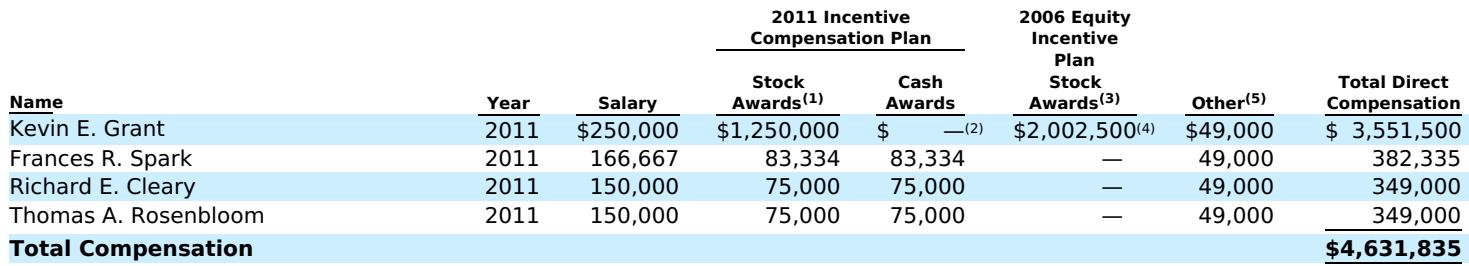


--- Record 2 ---
Company: CYS Investments, Inc.
Filing date: 2012-04-03T00:00:00
Accession: 0001193125-12-147588
Image: 620fe86e381a4f4343847ad7ed265413cd1ba3d1b2b6187427de8e94021e3b0a.jpg


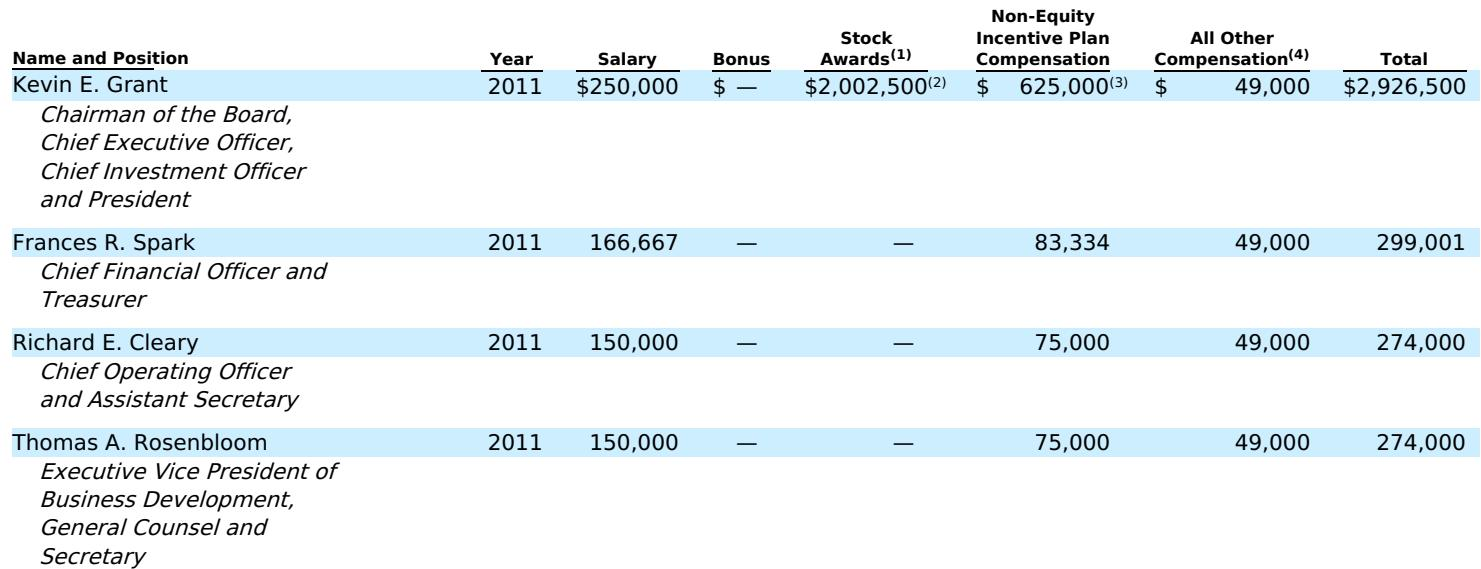

In [60]:
# Mostra un esempio di duplicato
if duplicates:
    # Prendi il primo duplicato
    example_key = list(duplicates.keys())[0]
    example_cik, example_year = example_key
    
    print(f"Esempio duplicato: CIK {example_cik}, Year {example_year}")
    print("="*60)
    
    # Trova tutti i record con questa chiave
    dup_records = [r for r in records if r["cik"] == example_cik and r["year"] == example_year]
    
    for i, rec in enumerate(dup_records):
        print(f"\n--- Record {i+1} ---")
        print(f"Company: {rec['company']}")
        print(f"Filing date: {rec['filing_date']}")
        print(f"Accession: {rec['accession_number']}")
        
        # Mostra immagine
        if rec.get("table_image"):
            print(f"Image: {Path(rec['table_image']).name}")
            display(PILImage.open(rec["table_image"]))

In [61]:
# Save dataset locally
hf_dataset.save_to_disk(str(BASE_PATH / "hf/execcomp-ai-sample"))
print(f"✓ Dataset saved to {BASE_PATH / 'hf/execcomp-ai-sample'}")

Saving the dataset (1/1 shards): 100%|██████████| 128/128 [00:00<00:00, 613.53 examples/s]

✓ Dataset saved to /home/pdipasquale/MIIA/stuff/hf/execcomp-ai-sample


In [62]:
# # =============================================================================
# # UPLOAD TO HUGGING FACE HUB
# # =============================================================================
# # Uncomment the following lines to upload the dataset to HuggingFace Hub
# # Make sure you're logged in: huggingface-cli login

# api = HfApi()
# hf_dataset.push_to_hub("pierjoe/execcomp-ai-sample")

## 6. Test New Prompts

Retest classification on specific documents to validate prompt changes.
Results saved to `tests/` folder to compare with original `output/`.

Duplicato -4/13: CIK 718877, Year 2016 (2 records)
Company: Activision Blizzard, Inc.
Link: https://www.sec.gov/Archives/edgar/data/718877/0001308179-16-000372-index.html

📋 Per testare, copia nella cella successiva:
    "718877_2016_0001308179-16-000372",


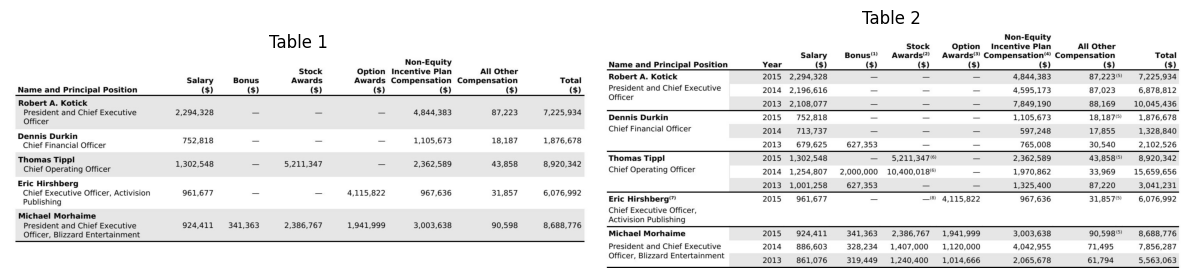

In [63]:
# Esplora duplicato specifico (cambia indice per navigare)
DUP_INDEX = -5  # Cambia questo per vedere altri duplicati

if duplicates and DUP_INDEX < len(duplicates):
    dup_keys = list(duplicates.keys())
    example_cik, example_year = dup_keys[DUP_INDEX]
    
    dup_records = [r for r in records if r["cik"] == example_cik and r["year"] == example_year]
    
    print(f"Duplicato {DUP_INDEX + 1}/{len(duplicates)}: CIK {example_cik}, Year {example_year} ({len(dup_records)} records)")
    print(f"Company: {dup_records[0]['company']}")
    print(f"Link: {dup_records[0]['filing_html_index']}")
    
    # Estrai source_doc dal path immagine
    if dup_records[0].get("table_image"):
        img_path = Path(dup_records[0]["table_image"])
        source_doc = img_path.parent.parent.parent.name
        print(f"\n📋 Per testare, copia nella cella successiva:")
        print(f'    "{source_doc}",')
    
    # Mostra tutte le immagini affiancate
    fig, axes = plt.subplots(1, len(dup_records), figsize=(6*len(dup_records), 8))
    if len(dup_records) == 1:
        axes = [axes]
    
    for i, (ax, rec) in enumerate(zip(axes, dup_records)):
        if rec.get("table_image"):
            img = PILImage.open(rec["table_image"])
            ax.imshow(img)
            ax.set_title(f"Table {i+1}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [64]:
# Configura test folder
TEST_OUTPUT_PATH = BASE_PATH / "tests"
TEST_OUTPUT_PATH.mkdir(exist_ok=True)

# Documenti da testare (inserisci i source_doc dei duplicati)
TEST_DOCS = ["718877_2016_0001308179-16-000372"
    # Aggiungi qui i source_doc da ritestare
    # es: "1000209_2019_0001193125-19-129364"
]

# Oppure: testa tutti i duplicati
if not TEST_DOCS and duplicates:
    for (cik, year) in list(duplicates.keys())[:5]:  # Max 5 duplicati
        dup_recs = [r for r in records if r["cik"] == cik and r["year"] == year]
        if dup_recs and dup_recs[0].get("table_image"):
            # Estrai source_doc dal path immagine
            img_path = Path(dup_recs[0]["table_image"])
            source_doc = img_path.parent.parent.parent.name
            if source_doc not in TEST_DOCS:
                TEST_DOCS.append(source_doc)

print(f"Documents to test: {len(TEST_DOCS)}")
for doc in TEST_DOCS:
    print(f"  - {doc}")

Documents to test: 1
  - 718877_2016_0001308179-16-000372


In [ ]:
# Reload prompts (importlib per ricaricare i moduli modificati)
import importlib
import src.vlm.prompts
import src.vlm.schemas
importlib.reload(src.vlm.prompts)
importlib.reload(src.vlm.schemas)
print("✓ Prompts reloaded")

In [ ]:
# Test sui documenti selezionati
for source_doc in tqdm(TEST_DOCS, desc="Testing"):
    # Crea struttura nella test folder
    test_doc_path = TEST_OUTPUT_PATH / source_doc
    test_doc_path.mkdir(exist_ok=True)
    
    # Copia metadata
    orig_meta = OUTPUT_PATH / source_doc / "metadata.json"
    if orig_meta.exists():
        import shutil
        shutil.copy(orig_meta, test_doc_path / "metadata.json")
        with open(orig_meta) as f:
            meta = json.load(f)
    
    # Classify
    found, all_classifications = await find_summary_compensation_in_doc(
        doc_source=source_doc,
        all_tables=all_tables,
        client=client,
        model=VLM_MODEL,
        base_path=BASE_PATH,
        display_func=display,
        plt_module=plt,
        pil_image_class=PILImage,
        debug=True  # Mostra output
    )
    
    # Merge
    if found:
        images_base_dir = OUTPUT_PATH / source_doc / source_doc / "vlm"
        found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=True)
    
    # Save classification results to test folder
    save_classification_results(found, test_doc_path, metadata=meta)
    
    # Mostra confronto
    print(f"\n{'='*60}")
    print(f"Document: {source_doc}")
    print(f"Tables found: {len(found) if found else 0}")
    
    if found:
        for i, f in enumerate(found):
            print(f"  Table {i+1}: {f.get('classification', {}).get('reason', 'N/A')[:80]}")

print("\n✓ Test complete. Results in tests/ folder")